In [4]:
import os
import random
import shutil
import pandas as pd
from itertools import permutations
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Utils

In [5]:
def fun(file):
    if 'txt' in file:
        return True  

def getfiles(dir_path):
    files = os.listdir(dir_path)
    return list(filter(fun, files))

def convert_16bytes_to_float(array, exponents=10):
    return (np.ascontiguousarray(array).view(dtype=np.int16) / (2 ** exponents)).squeeze()

def decode(data):  # decode raw sensor txt files
    sensordata = data[~data.iloc[:,0].str.startswith("[")].to_numpy().astype(np.float32).astype(np.uint8)

    data_dict = {'accX': convert_16bytes_to_float(sensordata[:,0:2]), 'accY': convert_16bytes_to_float(sensordata[:,2:4]), 'accZ': convert_16bytes_to_float(sensordata[:,4:6]), 'angX': convert_16bytes_to_float(sensordata[:,6:8]), 'angY': convert_16bytes_to_float(sensordata[:,8:10]), 'angZ': convert_16bytes_to_float(sensordata[:,10:12])}
    new_data = pd.DataFrame(data=data_dict)
    new_data['acc_scala'] = (new_data['accY'] ** 2 + new_data['accX'] ** 2 + new_data['accZ'] ** 2).apply(np.sqrt)[:].rolling(3, min_periods=1, center=True).mean()
    new_data['ang_scala'] = (new_data['angY'] ** 2 + new_data['angX'] ** 2 + new_data['angZ'] ** 2).apply(np.sqrt)[:].rolling(3, min_periods=1, center=True).mean()
    
    return new_data

def save_files(data, file_name, save_path):
    data.to_csv(save_path + file_name + '.txt', header=False, index=False)

def sampling(data, sampling_num):
    sampled_data = []
    data_col=data.columns
    data=data.to_numpy()
    for row in range(0, len(data), sampling_num):
        if row + sampling_num > len(data):
            extra_row = row + sampling_num - len(data)
            sampled_data.append(np.mean(data[row:row+extra_row],axis=0))
        else:
            sampled_data.append(np.mean(data[row:row+sampling_num,:],axis=0))        
    return pd.DataFrame(sampled_data,columns=data_col)

# Augment Functions

explanation how to use 'aug_module' function

-parameters-
- exercise : exercise name to augment
- aug_num : number of augment
- aug_mode : select augmentation methods (raw, split, warping, noise)

In [6]:
def augment_module(dir_path, save_path, exercise, aug_num, aug_reps=0, aug_mode='raw'):
    
    files = getfiles(dir_path)
    files = list(filter(lambda x: exercise in x , files)) # get specific exercise files
    
    if aug_mode == 'raw':
        for i in range(aug_num):
            file = random.choice(files)  # randomly select raw sensor data
            no_aug(dir_path, save_path, file)  # raw data sampling

    elif aug_mode == 'noise':
        for i in range(aug_num):
            file = random.choice(files)  # randomly select raw sensor data
            noise(dir_path, save_path, file)  # multiply and add noise

    elif aug_mode == 'warping':
        for i in range(aug_num):
            file = random.choice(files)  # randomly select raw sensor data
            time_warping(dir_path, save_path, file)
            
    elif aug_mode == 'split':
        # split : split based on workout border
        # split_merge : split data two parts based on workout border and merge them
        # permute : get permutations  that based on workout borders, and then data rearrangement 
        split_mode = ['split', 'split_merge', 'permute']
        for i in range(aug_num):
            file = random.choice(files)  # randomly select raw sensor data
            mode = random.choice(split_mode)  # randomly select split mode
            
            if mode == 'permute':
                permute(dir_path, save_path, file)
            elif mode == 'split':
                split(dir_path, save_path, file)
            elif mode == 'split_merge':
                split_merge(dir_path, save_path, file)
    
    elif aug_mode == 'reps_variation':
        files = getfiles(dir_path)

        if exercise != 'any':
            files = list(filter(lambda x: exercise in x , files))  # get specific exercise files

        if aug_reps == 8:
            files = list(filter(lambda x: int(x.split('_')[-1][0]) == 8 , files))
            for i in range(aug_num):
                file = random.choice(files)
                permute(dir_path, save_path, file)
        
        else:
            for i in range(aug_num):
                files = list(filter(lambda x: int(x.split('_')[-1][0]) > aug_reps, files))  # get specific exercise files
                file = random.choice(files)
                split_variation(dir_path, save_path, file, aug_reps)

In [7]:
def no_aug(dir_path, save_path, file): 
    data = pd.read_csv(dir_path + file, index_col=None, skiprows=[0], header=None)
    data.to_csv(save_path + file[:-4] + '_' + str(random.randint(0,10000)) +'_raw.txt', header=False, index=False)  # save raw data


def noise(dir_path, save_path, file):  
    data = pd.read_csv(dir_path + file, index_col=None, skiprows=[0], header=None)
    
    data = decode(data)
    
    data *= torch.normal(torch.tensor(1), torch.tensor(0.1), size=(1, 1)).item()
    data += torch.normal(torch.tensor(0), torch.tensor(1), size=(1, 1)).item()
    
    data.to_csv(save_path + file[:-4] +'_' + str(random.randint(0,10000)) + '_noise.txt', header=False, index=False)  # save noise augmented data


def time_warping(dir_path, save_path, file):    
    warping_lst = list(np.arange(55) + 18)  # 0.5 ~ 2 scaling divided by 36
    warp_ratio = random.choice(warping_lst)  # randomly select warping ratio

    data = pd.read_csv(dir_path + file, index_col=None, skiprows=[0], header=None)[:-1]
    data = data[~data.iloc[:,0].str.startswith("[")]
    decoded_data = decode(data)

    tmp = decoded_data.iloc[np.repeat(np.arange(len(decoded_data)), warp_ratio)].astype(int)
    warped_data = tmp.groupby(np.arange(len(tmp))//36).mean().astype(int)

    if len(data) <= 6000:  # augmented data lenghts must shorter than max_length(6000)
        # save time warp augmented data
        warped_data.to_csv(save_path + file[:-4] +'_' +  str(random.randint(0,10000)) + '_warping.txt', header=False, index=False)  


def permute(dir_path, save_path, file):
    data = pd.read_csv(dir_path + file, index_col=None, skiprows=[0], header=None)
    workout_borders = data[data.iloc[:,0].str.startswith("[Workout")][0]
    
    permute = list(permutations(range(int(file.split('_')[-1][0]))))
    permute = random.choice(permute)
    lst = [data.iloc[:workout_borders.index[0],:]]

    for i in permute:
        if i != len(permute)-1:
            lst.append(data.iloc[workout_borders.index[i*2]:workout_borders.index[i*2+2],:])
        else:
            lst.append(data.iloc[workout_borders.index[i*2]:,:])
    
    new = pd.concat(lst)

    # save permute augmented data
    new.to_csv(save_path + file[:-4] + '_' + str(random.randint(0,10000)) + '_permute.txt', header=False, index=False)  


def split(dir_path, save_path, file):
    data = pd.read_csv(dir_path + file, index_col=None, skiprows=[0], header=None)
    workout_borders = data[data.iloc[:,0].str.startswith("[Workout")][0]

    reps = int(file.split('_')[-1][0])
        
    for i in range(2, reps):
        new_data = data.iloc[:workout_borders.index[i*2]]

        # save split augmented data
        new_data.to_csv(save_path + file[:-5] + str(i) + '_' + str(random.randint(0,10000)) + '_split.txt' , header=False, index=False)


def split_merge(dir_path, save_path, file):
    data = pd.read_csv(dir_path + file, index_col=None, skiprows=[0], header=None)
    workout_borders = data[data.iloc[:,0].str.startswith("[Workout")][0]
    
    reps1 = random.randint(1, len(workout_borders) // 2 - 1)
    reps2 = random.randint(1, len(workout_borders) // 2 - 1)
    
    split_data1 = data.iloc[: workout_borders.index[reps1 * 2]]
    split_data2 = data.iloc[: workout_borders.index[reps2 * 2]]

    # merge two split data
    if reps1 + reps2 < 9:
        merged_data = pd.concat([split_data1, split_data2])

        # save merged data
        merged_data.to_csv(save_path + file[:-5] + str(reps1 + reps2) + '_' + str(random.randint(0,10000)) + '_merge.txt' , header=False, index=False)


def split_variation(dir_path, save_path, file, aug_reps):
    data = pd.read_csv(dir_path + file, index_col=None, skiprows=[0], header=None)
    workout_borders = data[data.iloc[:,0].str.startswith("[Workout")][0]

    reps = int(file.split('_')[-1][0])
    
    if reps != aug_reps:
        
        new_data = data.iloc[:workout_borders.index[aug_reps*2]]

        # save split augmented data
        new_data.to_csv(save_path + file[:-5] + str(aug_reps) + '_' + str(random.randint(0,10000)) + '_splitvariaton.txt' , header=False, index=False)

# Data to torch

In [8]:
import torch
import numpy as np
import pickle

def find_class(file):
    if 'squat' in file:
        return 0
    elif 'pushup' in file:
        return 1
    elif 'pullup' in file:
        return 2
    elif 'situp' in file:
        return 3
    elif 'deadlift' in file:
        return 4

In [9]:
def save_torch(dir_path, save_path, num, decoding=True):
    
    max_len = 60
    files = os.listdir(dir_path)

    max_len_list = []
    label = []
    count = []
    
    files = getfiles(dir_path)
    random.shuffle(files)
    for file in tqdm(files[:num], desc='make squence'):
        if '.ipynb' in file:
            continue
        
        data = pd.read_csv(dir_path + file, index_col=None, skiprows=[0], header=None)
        
        if decoding and 'warping' not in file and 'noise' not in file:
            data = decode(data.astype(str))
        
        # smoothing
        data = data.rolling(10).mean()
        
        # sampling
        data = sampling(data, sampling_num=10)

        # normalization
        data = (data - data.mean())/data.std()  
        if data.isnull().values.any():
            data = data.fillna(0)
        seq_list = []

        if len(data) < max_len * 10:
            pad = pd.DataFrame(np.zeros((max_len * 10 - len(data), 8)),columns=data.columns)
            cat_df = pd.concat([data, pad], axis=0).reset_index()
            cat_df = cat_df.drop(['index'], axis=1)
            
            for i in range(60):  # make sequence data
                seq_list.append(torch.tensor(np.array(cat_df.iloc[i*10 : i*10 + 10,:])))

            max_len_list.append(torch.stack(seq_list))
            label.append(torch.tensor(find_class(file)))
            count.append(torch.tensor(int(file.split('_')[1][0])))

    x_data = torch.stack(max_len_list).float()
    y_label = torch.stack(label).float()
    y_count = torch.stack(count).float()
    
    # save
    if mode == 'train':
        with open(save_path + dir_path.split('/')[-2] + '.pickle.pkl', 'wb') as f:  
            pickle.dump([x_data, y_label, y_count], f)
    else:
        with open(save_path + 'test.pickle.pkl', 'wb') as f:  
            pickle.dump([x_data, y_label, y_count], f)


# Main code

In [10]:
exercist_list = ['deadlift', 'pullup', 'situp', 'pushup', 'squat']

In [11]:
src_path = './raw_train/'  # raw sensordata for train
trg_path = './augmented_txt/' # target path to save augmented data

make augmented data
- aug_num : number of augment
- aug_mode : 'raw', 'split, 'warping', 'noise

In [29]:
# select augmentation mode [raw, split, warping, noise]
for exer in exercist_list:
    augment_module(dir_path=src_path, save_path=trg_path + 'raw/', exercise=exer, aug_num=6100, aug_mode='raw')
    augment_module(dir_path=src_path, save_path=trg_path + 'warping/', exercise=exer, aug_num=6100, aug_mode='warping')
    augment_module(dir_path=src_path, save_path=trg_path + 'noise/', exercise=exer, aug_num=6100, aug_mode='noise')
    augment_module(dir_path=src_path, save_path=trg_path + 'split/', exercise=exer, aug_num=4500, aug_mode='split')

adjusting data's exercise or reps distributions
- aug_num : number of augment
- aug_reps : number of augmenting that specific reps
- aug_mode : 'reps_variation'

options)    
    
Augment specific exercise : exercise = 'exercise_name'  
  
Augment unspecific exercise : exercise= 'any'  

In [38]:
augment_module(dir_path=src_path, save_path=trg_path + 'split/', exercise='any', aug_num=5000, aug_reps=8, aug_mode='reps_variation')
augment_module(dir_path=src_path, save_path=trg_path + 'split/', exercise='any', aug_num=4000, aug_reps=7, aug_mode='reps_variation')
augment_module(dir_path=src_path, save_path=trg_path + 'split/', exercise='any', aug_num=2500, aug_reps=6, aug_mode='reps_variation')
augment_module(dir_path=src_path, save_path=trg_path + 'split/', exercise='any', aug_num=2000, aug_reps=5, aug_mode='reps_variation')

In [12]:
def copy_files(dir_path, save_path, num):
       files = getfiles(dir_path)
       random.shuffle(files)
       
       for i in range(num):
              shutil.copy(dir_path + files[i], save_path)

In [13]:
dir_paths = [trg_path + 'raw/', trg_path + 'noise/', trg_path + 'split/', trg_path + 'warping/']

In [15]:
# copy from augmented data to all directory
for path in dir_paths:
    copy_files(path, trg_path + 'all/', 10000)

In [17]:
# check data length
path = 'augmented_txt/'
print('raw :', len(getfiles(path + 'raw/')))
print('split_merge :', len(getfiles(path + 'split/')))
print('time_warping :', len(getfiles(path + 'warping/')))
print('noise_injection :', len(getfiles(path + 'noise/')))
print('all_permuted :', len(getfiles(path + 'all/')))

raw : 30320
split_merge : 50847
time_warping : 30326
noise_injection : 30330
all_permuted : 40000


# Data Aggregation

In [20]:
def get_class_distribution(files, class_dict):
    for file in files:
        if '.ipynb' not in file:
            if 'squat' in file:
                class_dict['squat'] += 1
            elif 'pushup' in file:
                class_dict['pushup'] += 1
            elif 'pullup' in file:
                class_dict['pullup'] += 1
            elif 'situp' in file:
                class_dict['situp'] += 1
            elif 'deadlift' in file:
                class_dict['deadlift'] += 1
    return class_dict

def get_reps_distribution(files, reps_dict):
    for file in files:
        if '.ipynb' not in file:
            reps = int(file.split('_')[1][0])
            if reps == 2:
                reps_dict['2reps'] += 1
            elif reps == 3:
                reps_dict['3reps'] += 1
            elif reps == 4:
                reps_dict['4reps'] += 1
            elif reps == 5:
                reps_dict['5reps'] += 1
            elif reps == 6:
                reps_dict['6reps'] += 1
            elif reps == 7:
                reps_dict['7reps'] += 1
            elif reps == 8:
                reps_dict['8reps'] += 1
    return reps_dict

In [21]:
### get train data
train_raw = getfiles('augmented_txt/raw/')
train_raw_noi = getfiles('./augmented_txt/noise/')
train_raw_sp = getfiles('./augmented_txt/split/')
train_raw_tw = getfiles('./augmented_txt/warping/')
train_raw_all = getfiles('./augmented_txt/all/')

### get test data
test_raw = getfiles('./raw_test/')

# class dict
train_raw_class_dict = {'squat': 0, 'pushup': 0, 'pullup': 0, 'situp': 0, 'deadlift': 0}
train_raw_noi_dict = train_raw_class_dict.copy()
train_raw_sp_dict = train_raw_class_dict.copy()
train_raw_tw_dict = train_raw_class_dict.copy()
train_raw_all_dict = train_raw_class_dict.copy()

test_raw_dict = train_raw_class_dict.copy()

# reps dict
train_raw_reps_dict = {'2reps': 0, '3reps': 0, '4reps': 0, '5reps': 0, '6reps': 0, '7reps' : 0, '8reps' :0}
train_raw_noi_reps_dict = train_raw_reps_dict.copy()
train_raw_sp_reps_dict = train_raw_reps_dict.copy()
train_raw_tw_reps_dict = train_raw_reps_dict.copy()
train_raw_all_reps_dict = train_raw_reps_dict.copy()

test_raw_reps_dict = train_raw_reps_dict.copy()

# class files & dicts
list_of_files_class = [train_raw, train_raw_noi, train_raw_sp, train_raw_tw, train_raw_all, test_raw]
list_of_dicts_class = [train_raw_class_dict, train_raw_noi_dict, train_raw_sp_dict, train_raw_tw_dict, train_raw_all_dict, test_raw_dict]

# reps files & dicts
list_of_files_reps = [train_raw, train_raw_noi, train_raw_sp, train_raw_tw, train_raw_all, test_raw]
list_of_dicts_reps = [train_raw_reps_dict, train_raw_noi_reps_dict, train_raw_sp_reps_dict, train_raw_tw_reps_dict, train_raw_all_reps_dict, test_raw_reps_dict]

for i, items in enumerate(zip(list_of_files_class, list_of_dicts_class, list_of_files_reps, list_of_dicts_reps)):
    # print(len(items[0]))
    list_of_dicts_class[i] = get_class_distribution(items[0], items[1])
    list_of_dicts_reps[i] = get_reps_distribution(items[2], items[3])

### Class distribution

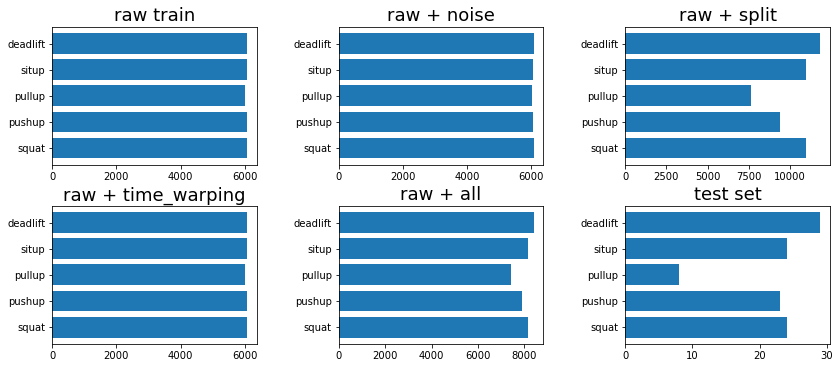

In [22]:
class_dict = list_of_dicts_class[0]

label = list(class_dict.keys())
index = np.arange(len(label))

# Basic Bar Chart
plt.subplot(2,3,1)
plt.barh(label, list_of_dicts_class[0].values())
plt.title('raw train', fontsize=18)

plt.subplot(2,3,2)
plt.barh(label, list_of_dicts_class[1].values())
plt.title('raw + noise', fontsize=18)

plt.subplot(2,3,3)
plt.barh(label, list_of_dicts_class[2].values())
plt.title('raw + split', fontsize=18)

plt.subplot(2,3,4)
plt.barh(label, list_of_dicts_class[3].values())
plt.title('raw + time_warping', fontsize=18)

plt.subplot(2,3,5)
plt.barh(label, list_of_dicts_class[4].values())
plt.title('raw + all', fontsize=18)

plt.subplot(2,3,6)
plt.barh(label, list_of_dicts_class[5].values())
plt.title('test set', fontsize=18)

# plt.tight_layout()
plt.subplots_adjust(left=0.2, bottom=0.1, right=2.0, top=1.2, wspace=0.4, hspace=0.3)
plt.show()

### Reps distribution

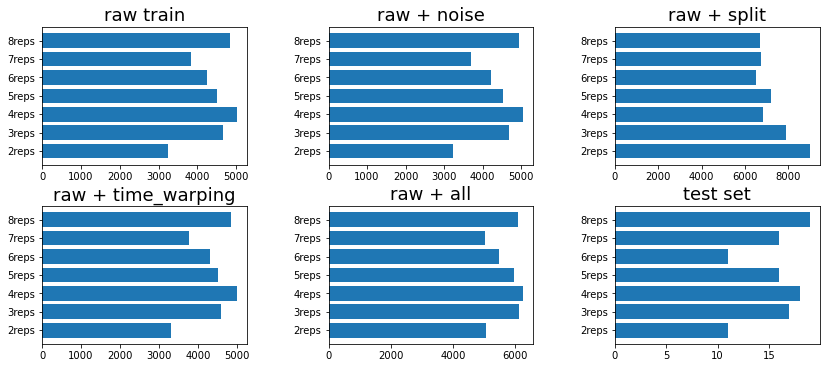

In [23]:
label = list(train_raw_reps_dict.keys())
index = np.arange(len(label))

# Basic Bar Chart
plt.subplot(2,3,1)
plt.barh(label, list_of_dicts_reps[0].values())
plt.title('raw train', fontsize=18)

plt.subplot(2,3,2)
plt.barh(label, list_of_dicts_reps[1].values())
plt.title('raw + noise', fontsize=18)

plt.subplot(2,3,3)
plt.barh(label, list_of_dicts_reps[2].values())
plt.title('raw + split', fontsize=18)

plt.subplot(2,3,4)
plt.barh(label, list_of_dicts_reps[3].values())
plt.title('raw + time_warping', fontsize=18)

plt.subplot(2,3,5)
plt.barh(label, list_of_dicts_reps[4].values())
plt.title('raw + all', fontsize=18)

plt.subplot(2,3,6)
plt.barh(label, list_of_dicts_reps[5].values())
plt.title('test set', fontsize=18)

# plt.tight_layout()
plt.subplots_adjust(left=0.2, bottom=0.1, right=2.0, top=1.2, wspace=0.4, hspace=0.3)
plt.show()

### Save_torch for train dataset

In [24]:
save_path_train = 'train_torch/'
save_path_test = 'test_torch/'

In [25]:
train_raw = getfiles('augmented_txt/raw/')
train_raw_noise = getfiles('augmented_txt/noise/')
train_raw_split = getfiles('augmented_txt/split/')
train_raw_warping = getfiles('augmented_txt/warping/')
train_raw_all = getfiles('augmented_txt/all/')

In [26]:
print(len(train_raw))
print(len(train_raw_noise))
print(len(train_raw_split))
print(len(train_raw_warping))
print(len(train_raw_all))

30320
30330
50847
30326
40000


In [27]:
src_path = 'augmented_txt/'

In [50]:
save_torch(src_path + 'raw/', save_path_train, 30000)
save_torch(src_path + 'noise/', save_path_train, 30000, decoding=False)
save_torch(src_path + 'split/', save_path_train, 30000)
save_torch(src_path + 'warping/', save_path_train, 30000, decoding=False)
save_torch(src_path + 'all/', save_path_train, 30000)

make squence: 100%|██████████| 30000/30000 [14:45<00:00, 33.88it/s]


### Save_torch for test dataset

In [54]:
len(getfiles('raw_test/'))

108

In [55]:
save_torch('./raw_test/', save_path_test, 157)

make squence: 100%|██████████| 108/108 [00:04<00:00, 24.85it/s]


### Plot torch data

In [56]:
import pickle
import matplotlib.pyplot as plt

In [57]:
with open('train_torch/raw.pickle.pkl', 'rb') as f:  
    x_data, y_label, y_count = pickle.load(f)

In [58]:
x_data.shape

torch.Size([10000, 60, 10, 8])

In [59]:
x_data_reshaped = x_data[2].reshape(-1, 8).permute(1, 0)

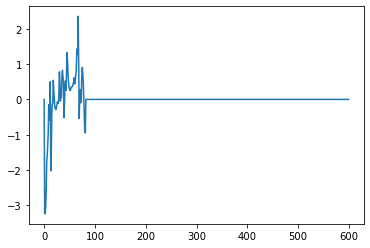

In [60]:
plt.plot(x_data_reshaped[2])

### rolling average test

In [61]:
files = getfiles('raw_test/')

In [62]:
len(files)

302

In [63]:
data = pd.read_csv('raw_test/' + files[0], index_col=None, skiprows=[0], header=None)

In [64]:
decoded_data = decode(data)
print(decoded_data)

           accX      accY      accZ  angX      angY      angZ  acc_scala  \
0     14.055664  5.785156 -7.726562   0.0  0.627930  0.106445  17.125131   
1     14.136719  5.807617 -7.889648   0.0  0.625000  0.106445  17.184975   
2     14.078125  5.855469 -8.183594   0.0  0.624023  0.162109  17.336271   
3     13.825195  6.648438 -8.430664   0.0  0.649414  0.203125  17.507562   
4     13.826172  7.043945 -8.542969   0.0  0.551758  0.152344  17.585700   
...         ...       ...       ...   ...       ...       ...        ...   
1890  13.108398  7.282227 -7.203125   0.0 -0.016602  0.001953  16.644583   
1891  13.066406  7.328125 -7.248047   0.0 -0.027344 -0.023438  16.638042   
1892  13.107422  7.268555 -7.219727   0.0 -0.025391 -0.034180  16.618936   
1893  13.035156  7.249023 -7.237305   0.0 -0.020508 -0.041992  16.589041   
1894  12.980469  7.303711 -7.221680   0.0 -0.013672 -0.041992  16.565496   

      ang_scala  
0      0.635444  
1      0.638541  
2      0.653059  
3      0.632526

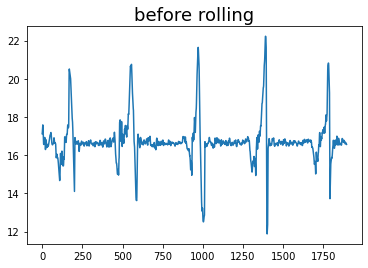

1895
1895


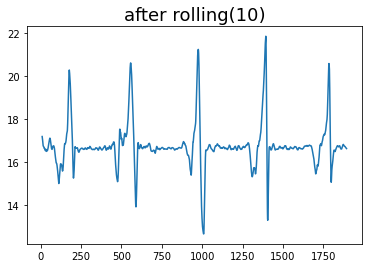

In [65]:
decoded_data['acc_scala'].plot()
plt.title('before rolling average', fontsize=18)
plt.show()
print(len(decoded_data))

rolled_data = decoded_data.rolling(10).mean()
rolled_data['acc_scala'].plot()
plt.title('after rolling average', fontsize=18)
print(len(decoded_data['acc_scala'].rolling(10).mean()))

In [67]:
sampled_data = sampling(rolled_data, 10)

<AxesSubplot:>

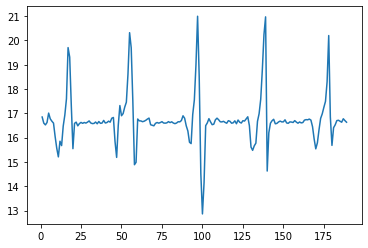

In [68]:
sampled_data['acc_scala'].plot()